In [33]:
# import statements
import numpy as np
import theano as th
from theano import tensor as T
from numpy import random as rng

In [58]:
class AutoEncoder(object):
    def __init__(self, X, hidden_size, activation_function,
                 output_function):
        #X is the data, an m x n numpy matrix
        #where rows correspond to datapoints
        #and columns correspond to features.
        assert type(X) is np.ndarray
        assert len(X.shape)==2
        self.X=X
        self.X=th.shared(name='X', value=np.asarray(self.X, 
                         dtype=th.config.floatX),borrow=True)
        #The config.floatX and borrow=True stuff is to get this to run
        #fast on the gpu. I recommend just doing this without thinking about
        #it until you understand the code as a whole, then learning more
        #about gpus and theano.
        self.n = X.shape[1]
        self.m = X.shape[0]
        #Hidden_size is the number of neurons in the hidden layer, an int.
        assert type(hidden_size) is int
        assert hidden_size > 0
        self.hidden_size=hidden_size
        initial_W = np.asarray(rng.uniform(
                 low=-4 * np.sqrt(6. / (self.hidden_size + self.n)),
                 high=4 * np.sqrt(6. / (self.hidden_size + self.n)),
                 size=(self.n, self.hidden_size)), dtype=th.config.floatX)
        self.W = th.shared(value=initial_W, name='W', borrow=True)
        self.b1 = th.shared(name='b1', value=np.zeros(shape=(self.hidden_size,),
                            dtype=th.config.floatX),borrow=True)
        self.b2 = th.shared(name='b2', value=np.zeros(shape=(self.n,),
                            dtype=th.config.floatX),borrow=True)
        self.activation_function=activation_function
        self.output_function=output_function
                    
    def train(self, n_epochs=100, mini_batch_size=1, learning_rate=0.1):
        index = T.lscalar()
        x=T.matrix('x')
        params = [self.W, self.b1, self.b2]
        hidden = self.activation_function(T.dot(x, self.W)+self.b1)
        output = T.dot(hidden,T.transpose(self.W))+self.b2
        output = self.output_function(output)
        
        #Use cross-entropy loss.
        L = -T.sum(x*T.log(output) + (1-x)*T.log(1-output), axis=1)
        cost=L.mean()       
        updates=[]
        
        #Return gradient with respect to W, b1, b2.
        gparams = T.grad(cost,params)
        
        #Create a list of 2 tuples for updates.
        for param, gparam in zip(params, gparams):
            updates.append((param, param-learning_rate*gparam))
        
        #Train given a mini-batch of the data.
        train = th.function(inputs=[index], outputs=[cost], updates=updates,
                            givens={x:self.X[index:index+mini_batch_size,:]})
                            

        import time
        start_time = time.clock()
        for epoch in xrange(n_epochs):
            print "Epoch:",epoch
            for row in xrange(0,self.m, mini_batch_size):
                train(row)
        end_time = time.clock()
        print "Average time per epoch=", (end_time-start_time)/n_epochs
                   
    def get_hidden(self,data):
        x=T.dmatrix('x')
        hidden = self.activation_function(T.dot(x,self.W)+self.b1)
        transformed_data = th.function(inputs=[x], outputs=[hidden])
        return transformed_data(data)
    
    def get_weights(self):
        return [self.W.get_value(), self.b1.get_value(), self.b2.get_value()]

In [6]:
-

In [23]:
# helper to plot filters

%matplotlib inline 

import matplotlib.pyplot as plt

def plot_first_k_numbers(X,k):
    m=X.shape[0]
    k=min(m,k)
    j = int(round(k / 10.0))
    
    fig, ax = plt.subplots(j,10)
   
    for i in range(k):

        w = X[i,:]

        
        w = w.reshape(28,28)
        ax[i/10, i%10].imshow(w,cmap=plt.cm.gist_yarg,
                      interpolation='nearest', aspect='equal')
        ax[i/10, i%10].axis('off')

    
    plt.tick_params(\
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.tick_params(\
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off', 
        right='off',    # ticks along the top edge are off
        labelleft='off')
    
    fig.show()

... loading data
Epoch: 0
Average time per epoch= 29.247185


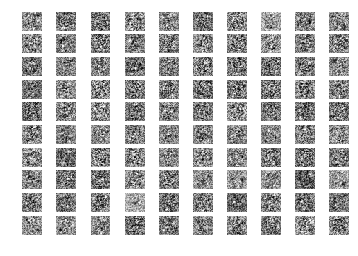

In [60]:
path="/Users/Chris/Github/deeplearnEDU/autoencoder/mnist.pkl.gz"
 
data = load_data(path)

def m_test(data):
    X=data[0][0]
    activation_function = T.nnet.sigmoid
    output_function=activation_function
    A = AutoEncoder(X, 500, activation_function, output_function)
    A.train(1,20)
    W=np.transpose(A.get_weights()[0])
    plot_first_k_numbers(W, 100)
 
m_test(data) 